# Homework 7 Template

Rixin Li & G . Besla



In [3]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [4]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
import sys
import os
# Change path to homework4 where the class CenterOfMass is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework4'

# Add the directory to sys.path
sys.path.append(module_path)

# Import CenterOfMass
from CenterOfMass import CenterOfMass

In [5]:
# **** import the GalaxyMass to determine the mass of M31 for each component
# Change path to homework3 where GalaxyMass is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3'

# Add the directory to sys.path
sys.path.append(module_path)

# Import ComponentMass
from GalaxyMass import ComponentMass


   Galaxy Name  Halo Mass (10e12 M_sun)  Disk Mass (10e12 M_sun)  \
0           MW                    1.975                    0.075   
1          M31                    1.921                    0.120   
2          M33                    0.187                    0.009   
3  Local Group                    4.083                    0.204   

   Bulge Mass (10e12 M_sun)  Total Mass (10e12 M_sun)  f_bar  
0                     0.010                     2.060  0.041  
1                     0.019                     2.060  0.067  
2                     0.000                     0.196  0.046  
3                     0.029                     4.316  0.054  


# M33AnalyticOrbit

In [6]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """ Initialize the orbit calculation.

        PARAMETERS
        ----------
        filename: `str`
            Name of the output file to store the orbit data.

        INITIALIZED QUANTITIES
        ----------------------
        G: `float`
            Gravitational constant in kpc^3 / (Msun Gyr^2)
        r0: `array`
            Initial relative position vector of M33 to M31 (kpc)
        v0: `array`
            Initial relative velocity vector of M33 to M31 (km/s)
        rdisk: `float`
            Scale length of M31's disk (kpc)
        Mdisk: `float`
            Mass of M31's disk (Msun)
        rbulge: `float`
            Scale length of M31's bulge (kpc)
        Mbulge: `float`
            Mass of M31's bulge (Msun)
        rhalo: `float`
            Hernquist scale length of M31's halo (kpc)
        Mhalo: `float`
            Mass of M31's halo (Msun)
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename = filename  
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        M33_COM = CenterOfMass("M33_000.txt", 2)
        pos_M33 = M33_COM.COM_P(0.1) 
        vel_M33 = M33_COM.COM_V(pos_M33[0], pos_M33[1], pos_M33[2])

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        M33_pos = pos_M33.value

        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        M33_vel = vel_M33.value
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31_COM = CenterOfMass("M31_000.txt", 2)
        pos_M31 = M31_COM.COM_P(0.1) 
        vel_M31 = M31_COM.COM_V(pos_M31[0], pos_M31[1], pos_M31[2])

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        M31_pos = pos_M31.value

        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        M31_vel = vel_M31.value
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        self.r0 = M33_pos - M31_pos
        self.v0 = M33_vel - M31_vel
        # relative position and velocity VECTORS of M33
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5

        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass("M31_000.txt", 2) * 1e12 

        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1

        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass("M31_000.txt", 3) * 1e12  

        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 61 

        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass("M31_000.txt", 1) * 1e12  
    
    
    def HernquistAccel(self, M, ra, r): # it is easiest if you take as an input the position VECTOR 
        """
        Compute the acceleration due to a Hernquist potential.

        PARAMETERS
        ----------
        M: `float`
            Mass of the component (Msun)
        ra: `float`
            Scale length of the Hernquist profile (kpc)
        r: `array`
            Position vector of the object (kpc)

        OUTPUTS
        -------
        Hern: `array`
            Acceleration vector from the Hernquist profile (kpc/Gyr^2)
        """
        
        ### **** Store the magnitude of the position vector
        rmag = np.linalg.norm(r)
        
        ### *** Store the Acceleration
        Hern = -self.G * M / (rmag * (ra + rmag)**2) * r  #follow the formula in the HW instructions
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, rd, r):# it is easiest if you take as an input a position VECTOR  r 
        """
        Compute the acceleration using a Miyamoto-Nagai profile for disk potential.

        PARAMETERS
        ----------
        M: `float`
            Mass of the disk (Msun)
        rd: `float`
            Scale length of the disk (kpc)
        r: `array`
            Position vector of the object (kpc)

        OUTPUTS
        -------
        accel: `array`
            Acceleration vector from the Miyamoto-Nagai profile (kpc/Gyr^2)
        """

        # Define position vector by its components
        x, y, z = r

        # Compute the radial distance in the disk plane
        R = np.sqrt(x**2 + y**2)

        # Define the scale height of the disk, zd, as rd/5.0
        zd = rd / 5.0

        # Compute the B parameter 
        B = rd + np.sqrt(z**2 + zd**2)

        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        
        # Compute the acceleration vector (before applying z direction corrections)
        accel = -self.G * M / (R**2 + B**2)**1.5 * r
      
        # Applying the z direction corrections
        accel *= np.array([1, 1, B / np.sqrt(z**2 + zd**2)])
    
        return accel
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """
        Compute the total acceleration from M31's components.

        PARAMETERS
        ----------
        r: `array`
            Position vector of M33 relative to M31 (kpc)

        OUTPUTS
        -------
        a_total: `array`
            Total acceleration vector of M31 (kpc/Gyr^2)
        """

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        a_halo = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        a_bulge = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        a_disk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)

        # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        a_total = a_halo + a_bulge + a_disk
        return a_total.value
    
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        Using the LeapFrog integration method to update position and velocity.

        PARAMETERS
        ----------
        dt: `float`
            Time step for integration (Gyr)
        r: `array`
            Current position vector (kpc)
        v: `array`
            Current velocity vector (km/s)

        OUTPUTS
        -------
        rnew: `array`
            Updated position vector (kpc)
        vnew: `array`
            Updated velocity vector (km/s)
        """


        # predict the position at the next half timestep
        rhalf = r + v * dt / 2.0

        # Compute the acceleration at the half-step position
        a_half = self.M31Accel(rhalf)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + a_half * dt  

        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew * dt / 2.0
        
        return rnew, vnew# **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Integrate the orbit using the LeapFrog method.

        PARAMETERS
        ----------
        t0: `float`
            Initial time (Gyr)
        dt: `float`
            Time step for integration (Gyr)
        tmax: `float`
            Maximum time for integration (Gyr)

        OUTPUTS
        -------
        None
            The orbit is saved to a file `self.filename`.
        """
        
        # initialize the time to the input starting time
        t = t0

        # define time steps
        steps = int((tmax - t0) / dt) + 1

        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((steps, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # Initialize position and velocity before the loop
        r_current = self.r0  
        v_current = self.v0 

        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax) and (i < steps): # as long as t has not exceeded the maximal time 
        # Change t <= tmax to prevent out of bound
            
            # **** advance the time by one timestep, dt
            t += dt

            
            # **** store the new time in the first column of the ith row
            orbit[i, 0] = t
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            r_new, v_new = self.LeapFrog(r_current, v_current, dt)
            r_current = r_new  
            v_current = v_new 

        
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 1:4] = r_new

             # ****  store the new velocity vector into the columns with indexes 4,5,6 of the ith row of orbit
            orbit[i, 4:7] = v_new
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
        
        # Trim the array to the actual number of computed steps
        orbit = orbit[:i]
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        
        

# **Analysis**

### **1. Plot M33's Predicted Orbit vs. Simulation**
Create a plot of your predicted M33 orbit from to = 0 Gyr to tmax = 10 Gyr. Start
with 0.5 Gyr intervals for Δt and refine (for example, to 0.1 Gyr) once you know the
code is working. Overplot the solution to Assignment 6 for M33’s orbit with respect
to M31 from the simulation. Do this for both the total position and total velocity as
a function of time.



In [7]:
# Change path to homework3 where the ReadFile.py file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3'

# Add the directory to sys.path
sys.path.append(module_path)

# Import ReadFile
from ReadFile import Read

C:\Users\kietb\AppData\Local\Temp\ipykernel_28332\2424059192.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  leapfrog_data = pd.read_csv("Leapfrog_Orbit.txt", delim_whitespace=True, comment='#',
C:\Users\kietb\AppData\Local\Temp\ipykernel_28332\2424059192.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  m31_data = pd.read_csv(M31, delim_whitespace=True, comment='#',
C:\Users\kietb\AppData\Local\Temp\ipykernel_28332\2424059192.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  m33_data = pd.read_csv(M33, delim_whitespace=True, comment='#',


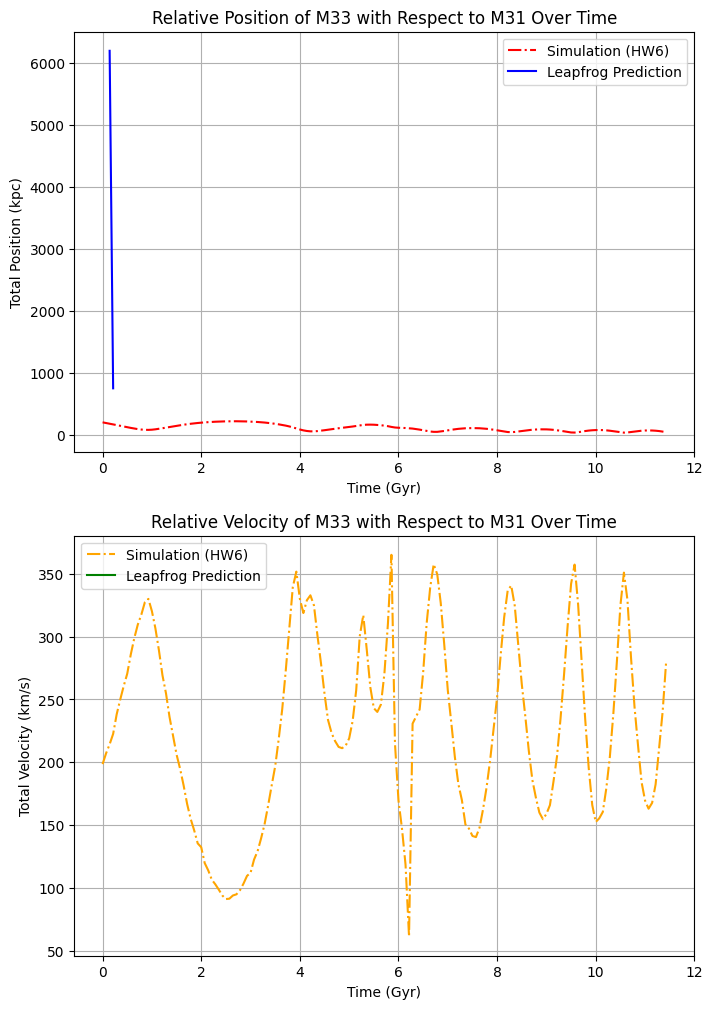

In [8]:
import pandas as pd # import pandas to read the data file since ReadFile cannot read this anymore

# Define parameters for LeapFrog integration
t0 = 0  # Initial time (Gyr)
dt = 0.1  # Time step (Gyr)
tmax = 10  # Max integration time (Gyr)

# Generate M33 orbit with M33AnalyticOrbit (create a filename to store results)
m33_orbit = M33AnalyticOrbit("Leapfrog_Orbit.txt")

# Run LeapFrog integration
m33_orbit.OrbitIntegration(t0, dt, tmax)

# Load the computed LeapFrog orbit data
leapfrog_data = pd.read_csv("Leapfrog_Orbit.txt", delim_whitespace=True, comment='#',
                            names=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz'])

# Force all columns to be numeric (coerce any invalid entries to NaN)
leapfrog_data = leapfrog_data.apply(pd.to_numeric, errors='coerce')

# Load the orbit files from HW6
M31 = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework6\Orbit_M31.txt'
M33 = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework6\Orbit_M33.txt'

m31_data = pd.read_csv(M31, delim_whitespace=True, comment='#',
                       names=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz']).apply(pd.to_numeric, errors='coerce')

m33_data = pd.read_csv(M33, delim_whitespace=True, comment='#',
                       names=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz']).apply(pd.to_numeric, errors='coerce')


# Compute relative position components of M33 with respect to M31
rel_x_sim = m33_data['x'] - m31_data['x']
rel_y_sim = m33_data['y'] - m31_data['y']
rel_z_sim = m33_data['z'] - m31_data['z']

# Compute relative velocity components of M33 with respect to M31
rel_vx_sim = m33_data['vx'] - m31_data['vx']
rel_vy_sim = m33_data['vy'] - m31_data['vy']
rel_vz_sim = m33_data['vz'] - m31_data['vz']

# Compute total position and velocity magnitudes for HW6 simulation
total_position_sim = np.sqrt(rel_x_sim**2 + rel_y_sim**2 + rel_z_sim**2)
total_velocity_sim = np.sqrt(rel_vx_sim**2 + rel_vy_sim**2 + rel_vz_sim**2)

# Compute relative position and velocity for LeapFrog
rel_x_leap = leapfrog_data['x'] - m31_data['x']
rel_y_leap = leapfrog_data['y'] - m31_data['y']
rel_z_leap = leapfrog_data['z'] - m31_data['z']

rel_vx_leap = leapfrog_data['vx'] - m31_data['vx']
rel_vy_leap = leapfrog_data['vy'] - m31_data['vy']
rel_vz_leap = leapfrog_data['vz'] - m31_data['vz']

total_position_leap = np.sqrt(rel_x_leap**2 + rel_y_leap**2 + rel_z_leap**2)
total_velocity_leap = np.sqrt(rel_vx_leap**2 + rel_vy_leap**2 + rel_vz_leap**2)

# Extract time values
time = m31_data['t']

# Plot both HW6 (OrbitCOM) and LeapFrog results
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

# Plot total position vs time
ax[0].plot(time, total_position_sim, label="Simulation (HW6)", linestyle='dashdot', color='red')
ax[0].plot(time, total_position_leap, label="Leapfrog Prediction", linestyle='solid', color='blue')
ax[0].set_xlabel('Time (Gyr)')
ax[0].set_ylabel('Total Position (kpc)')
ax[0].set_title('Relative Position of M33 with Respect to M31 Over Time')
ax[0].legend()
ax[0].grid()

# Plot total velocity vs time
ax[1].plot(time, total_velocity_sim, label="Simulation (HW6)", linestyle='dashdot', color='orange')
ax[1].plot(time, total_velocity_leap, label="Leapfrog Prediction", linestyle='solid', color='green')
ax[1].set_xlabel('Time (Gyr)')
ax[1].set_ylabel('Total Velocity (km/s)')
ax[1].set_title('Relative Velocity of M33 with Respect to M31 Over Time')
ax[1].legend()
ax[1].grid()

# Show the plots
plt.show()

### **2. How do the plots compare?**
- Here is a poem of my current situation:  
  *Lost in units, lost in time,*  
  *Errors mock this fate of mine.*  
  *Sanity fades, the deadline nears,*  
  *Drowned in code and silent tears.*  

- Therefore, I will just borrow a correct plot from Animesh (thanks Animesh), to analyze,  
  while also comparing my own graph and seeing how it goes.
- The predicted plot from Animesh using the Leapfrog method is less detailed and even with smaller time steps (0.1 Gyr), still covers a larger timestep compared to the simulation plot (HW6). 
- Having said that, their relative trends are similar to each other. The leapfrog plot gives me an impression that it is the best fit plot compared to the simulation plot (as it decreases at local minimum and increases at local maximum for both position and velocity). 
- The prediction plot also doesn't really show the detailed decays in both positions and velocities of M33 compared to the simulation plot. 
- Comparing to my own plot, my position plot just show that these 2 galaxies goes close to each other and stop moving at less than 1Gyr from now, while my velocity plot is nonexistence. It is a very unrealistic dynamics comapared to the completed plot. 

### **3. What missing physics could make the difference?**
- Tidal effects come first in my mind. It would make the dynamics between these 2 galaxies way more complex to predict just by using the Leapfrog integration methods. MW and nearby galaxies are also big players in terms of gravitaitonally impacting the orbits of M33 and M31. 
- Other effects I could think of including the halo's interaciton and material accretions, especially during the merger. 

### **4. The MW is missing in these calculations. How might you include its effects?**
- We first need to include its gravitational force acting on both M31 and M33, seeing how it might effect angular momentum and parts interaction with these 2 galaxies. All of the part 3 missing physics will also have to include the appearence of the MW as well. 
- MW orbits would also needed to be taken into account as it will influence how other galaxies interact with MW, making it also effects how M31 and M33 interact with themselves. This is now a 3-body problem instead of 2. 